In [15]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import numpy.random as npr

import pandas as pd
import pickle as pkl
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

from collections import defaultdict, namedtuple

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar
from matplotlib import rc
%matplotlib inline

import scipy as sp

plt.style.use('bmh')
rc('font', **{'family':'sans-serif', 'sans-serif': ['DejaVu Sans']})
rc('text', usetex=True)

import itertools
from glob import glob

import seaborn as sns

import sys
sys.path.append('..')

from regression import EnergyNet, UnrollEnergyGD, UnrollEnergyCEM
from dcem import dcem
# import util

In [16]:
def to_np(tensor_arr):
    np_arr = tensor_arr.detach().cpu().numpy()
    return np_arr


In [17]:
def plot(x_train, y_train, Enet=None, pred_model=None, ax=None, norm=True, show_cbar=True):
    x = np.linspace(0., 2.*np.pi, num=500)
    y = np.linspace(-7., 7., num=500)
#     x = np.linspace(-1., 1.)
#     y = np.linspace(-1., 1., 50)
#     x = np.linspace(-100., 100.)
#     y = np.linspace(-100., 100.)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))
    else:
        fig = ax.get_figure()
    
    ax.plot(to_np(x_train), to_np(y_train), color='k')

    if Enet is not None:
        X, Y = np.meshgrid(x, y)
        Xflat = torch.from_numpy(X.reshape(-1)).float().to(x_train.device).unsqueeze(1)
        Yflat = torch.from_numpy(Y.reshape(-1)).float().to(x_train.device).unsqueeze(1)
        Zflat = to_np(Enet(Xflat, Yflat))
        Z = Zflat.reshape(X.shape)
        
        if norm:
            Zmin = Z.min(axis=0)
            Zmax = Z.max(axis=0)
#             Zmax = np.quantile(Z, 0.75, axis=0)
            Zrange = Zmax-Zmin
            Z = (Z - np.expand_dims(Zmin, 0))/np.expand_dims(Zrange, 0)
            Z[Z > 1.0] = 1.0
            Z = np.log(Z+1e-6)
            Z = np.clip(Z, -10., 0.)
            CS = ax.contourf(X, Y, Z, cmap=cm.Blues, levels=10, vmin=-10., vmax=0., extend='min', alpha=0.8)
#             CS = ax.contourf(X, Y, Z, cmap=cm.Blues, levels=10, vmin=0., vmax=1., extend='max', alpha=0.8)
        else:
            CS = ax.contourf(X, Y, Z, cmap=cm.Blues, levels=10)

        if show_cbar:
            fig.colorbar(CS, ax=ax)
        
    if pred_model is not None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        ypreds = pred_model(x_train.unsqueeze(1)).squeeze()
        ax.plot(to_np(x_train), to_np(ypreds), color=colors[6], linestyle='--')
        
    return fig, ax, Z

In [18]:
def smooth(x, y, N):
    y = np.convolve(y, np.full((N,), 1./N), mode='valid')
    x = x[N-1:]
    return x,y

In [19]:
plot_dir = '../local/regression/plots'
os.makedirs(plot_dir, exist_ok=True)

In [20]:
Exp = namedtuple('Exp', 'results latest')
exps = defaultdict(list)
for root in glob('../local/regression/*'):
    fname = root+'/loss.csv'
    if not os.path.exists(fname):
        continue
    results = pd.read_csv(fname)
    fname = root+'/latest.pkl'
    latest = pkl.load(open(fname, 'rb'))
    tag = os.path.split(root)[1]
    method, seed = tag.split('.')
    exps[method].append(Exp(results, latest))


In [21]:
# Sorry, super-messy here
all_losses = {}
for method, method_exps in exps.items():
    n_seeds = len(method_exps)
    min_iter = min([len(method_exps[i].results['loss'].values) for i in range(n_seeds)])
    num_updates = method_exps[0].results['iter'].values[:min_iter]
    losses = np.vstack([method_exps[i].results['loss'].values[:min_iter] for i in range(n_seeds)])
    

    x = num_updates
    y = losses
    _x = np.linspace(x.min(), x.max(), num=200)
    _y = sp.interpolate.interp1d(x, y)(_x)
    num_updates = _x
    losses = _y
    
    df = pd.DataFrame(losses.T)
    df.index = num_updates
    df = df.T
    df = df.melt()
    df.columns = ['num_updates', 'loss']
    all_losses[method] = df


In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

sns.lineplot(
    x='num_updates', y='loss', data=all_losses['gd'], ax=ax,
    label='Unrolled GD', ci=95,
)
sns.lineplot(
    x='num_updates', y='loss', data=all_losses['dcem'], ax=ax,
    label='DCEM', ci=95,
)

ax.set_xlabel('Number of Updates')
ax.set_xlim(0, 60000)
ax.set_yscale('log')
ax.set_ylabel('')
ax.set_title('MSE Loss')
ax.legend()
fig.tight_layout()

fig.savefig(plot_dir+'/mse-loss.pdf')

KeyError: 'gd'

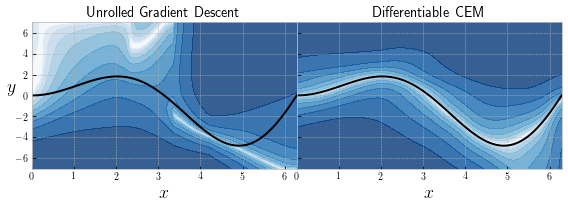

In [10]:
ncol = 2
fig, axs = plt.subplots(1, ncol, figsize=(4*ncol, 3), gridspec_kw = {'wspace':0, 'hspace':0})

ax = axs[0]
norm = True
exp = exps['gd'][0].latest
plot(exp.x_train, exp.y_train, Enet=exp.Enet, ax=ax, norm=norm, show_cbar=False)
sz = 18
ax.set_xlabel('$x$', fontsize=sz)
ax.set_ylabel('$y$', rotation=0, fontsize=sz)
ax.set_title('Unrolled Gradient Descent')

ax = axs[1]
exp = exps['dcem'][0].latest
ax.set_title('Differentiable CEM')
plot(exp.x_train, exp.y_train, Enet=exp.Enet, ax=ax, norm=norm, show_cbar=False)
ax.set_xlabel('$x$', rotation=0, fontsize=sz)
ax.get_yaxis().set_ticklabels([])
# fig.suptitle('(Normalized) Energy Surfaces', fontsize=20)
fig.tight_layout()
fig.savefig(plot_dir+'/E-surfaces.pdf')

In [11]:
x_train = exps['gd'][0].latest.x_train
y_train = exps['gd'][0].latest.y_train

n_inner_iters = list(range(1,20+1))
all_losses = defaultdict(list)

for seed in range(len(exps['gd'])):
    model = exps['gd'][seed].latest.model
    losses = []
    for n_inner_iter in n_inner_iters:
        model.n_inner_iter = n_inner_iter-1
        preds = model(x_train.unsqueeze(1)).squeeze()
        loss = F.mse_loss(input=preds, target=y_train)
        losses.append(loss.item())
    all_losses['gd'].append(np.array(losses))

    model = exps['dcem'][seed].latest.model
    losses = []
    for n_inner_iter in n_inner_iters:
        model.n_iter = n_inner_iter
        with torch.no_grad():
            preds = model(x_train.unsqueeze(1)).squeeze()
        loss = F.mse_loss(input=preds, target=y_train)
        losses.append(loss.item())
    all_losses['dcem'].append(np.array(losses))

for method, losses in all_losses.items():
    df = pd.DataFrame(np.vstack(losses))
    df = df.melt()
    df.columns = ['num_unroll_steps', 'loss']
    all_losses[method] = df

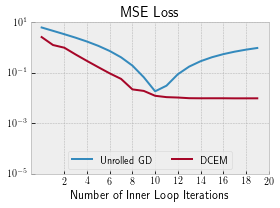

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

sns.lineplot(
    x='num_unroll_steps', y='loss', data=all_losses['gd'], ax=ax,
    label='Unrolled GD', ci=95,
)
sns.lineplot(
    x='num_unroll_steps', y='loss', data=all_losses['dcem'], ax=ax,
    label='DCEM', ci=95,
)

ax.set_ylim(1e-5, 1e1)
ax.set_yscale('log')
ax.set_xlabel('Number of Inner Loop Iterations')
ax.set_ylabel('')
ax.set_xticks(np.arange(2, 20+2, step=2))
ax.set_title('MSE Loss')
ax.legend(ncol=2, loc='lower center')

fig.tight_layout()
fig.savefig(plot_dir+'/inner-iter-ablation.pdf')

In [13]:
all_preds = defaultdict(list)

model = exps['gd'][3].latest.model
for n_inner_iter in n_inner_iters:
    model.n_inner_iter = n_inner_iter
    preds = model(x_train.unsqueeze(1)).squeeze()
    all_preds['gd'].append(preds)
    
model = exps['dcem'][4].latest.model
for n_inner_iter in n_inner_iters:
    model.n_iter = n_inner_iter
    with torch.no_grad():
        preds = model(x_train.unsqueeze(1)).squeeze()
    all_preds['cem'].append(preds)


fig, axs = plt.subplots(1, 2, figsize=(4*2, 2.5), gridspec_kw = {'wspace':0, 'hspace':0})
ax = axs[0]
ax.set_title('Unrolled Gradient Descent')

colors = np.vstack((
    cm.Reds(np.linspace(0.9, 0.2, num=10)),
    cm.Blues(np.linspace(0.2, 0.9, num=20))
))
for i, preds in enumerate(all_preds['gd']):
    ax.plot(util.to_np(x_train), util.to_np(preds), color=colors[i])
    
ax.plot(util.to_np(x_train), util.to_np(y_train), color='k')
ax.set_xlabel('$x$', fontsize=sz)
ax.set_ylabel('$y$', rotation=0, fontsize=sz)
ax.set_ylim(-7.5, 3.)
    
ax = axs[1]
ax.set_title('Differentiable CEM')
ax.get_yaxis().set_ticklabels([])
ax.set_xlabel('$x$', fontsize=sz)

for i, preds in enumerate(all_preds['cem']):
    ax.plot(util.to_np(x_train), util.to_np(preds), color=colors[i])

l, = ax.plot(util.to_np(x_train), util.to_np(y_train), color='k')

ax.set_ylim(-7.5, 3.)
# fig.suptitle('Model Predictions', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.82)

fig.savefig(plot_dir+'/inner-iter-ablation-vis.pdf')

IndexError: list index out of range

In [29]:
sns.palplot(colors, size=0.5)

NameError: name 'colors' is not defined